#### WHAT ARE WE BUILDING TODAY?  

In this notebook, we'll focus on building an interesting application using **Whisper, NeMo MSDD, and LanceDB** to create an end-to-end speaker-mapped transcription from an audio file.

We'll extract speakers from the audio, generate its transcription using Whisper models, perform diarization to identify the number of speakers and map them with timestamps, and then use LanceDB to match these speakers with their correct names from a database of known speakers.  

I believe this notebook will give you a kickstart in developing an end-to-end product and exploring how these technologies can be used to create innovative solutions. If you build something using this, share it on social media and tag me and LanceDB in your post.  

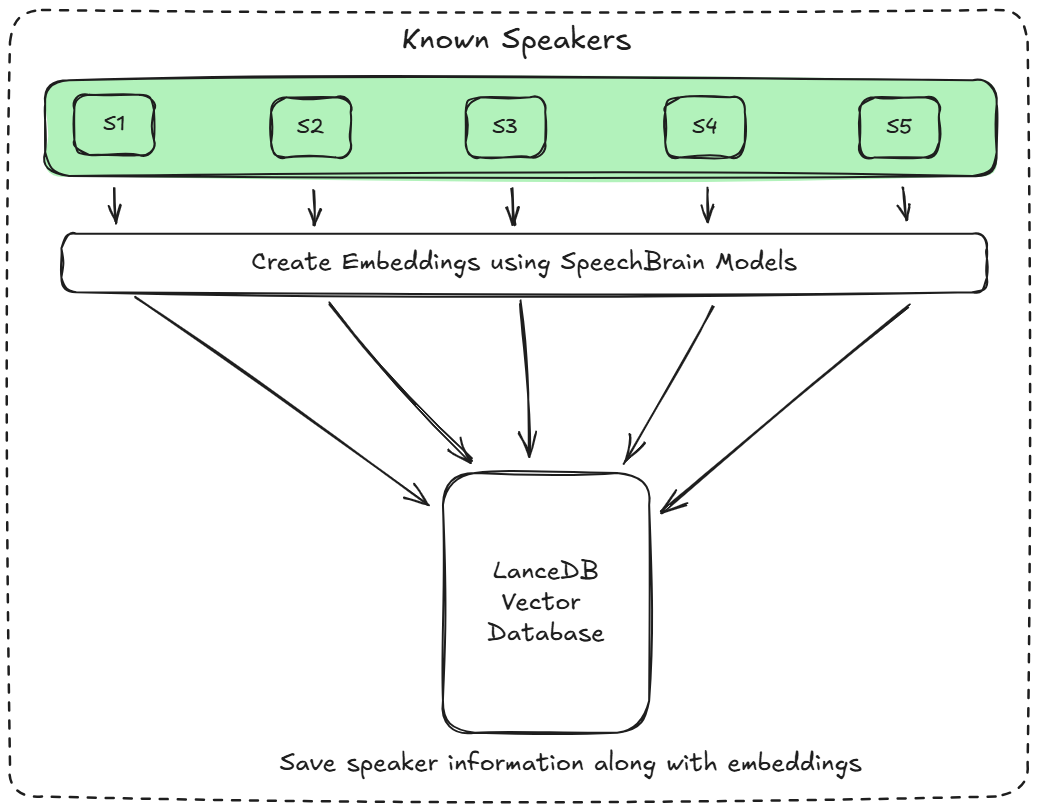

#### How to use this notebook?

I found a few resource on the internet that can help you with end to end processing of multiple stages of this project. I'll be using some part of these resources in this notebook while building this project with all credits to the original creators.

Notebook -https://shorturl.at/37hfR

Blog - https://ufarooqi.com/blog/speaker-diarization-for-whisper-transcripts/?utm_source=chatgpt.com

Sharing them because they are worth a read. Once you go through the concepts, you can use this notebook better to build speaker mapped transcription using LanceDB.

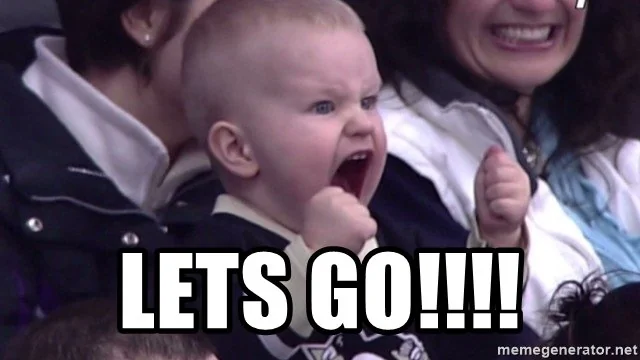

1. First, we'll see a naive transcription using whisper and identify the issues with it.

2. Then we'll figure out how to connect LanceDB with Azure Blob Storage to use this in current application.

3. Once we are done with both of these steps, we'll jump onto building our project and create a speaker mapped transcription for an audio file

#### Install Necessary Libraries

In [1]:
#note that the process is memory intensive. For experimentation, You can simply test transcription and diarization separately or if doing it together along with creating embeddings, make sure your colab has enough compute available. I'll prefer switching to local setup. It'll be slow but it'll work lol :)

#comment/uncomment these commands and install as required.
#for audio embeddings

!pip install torchaudio speechbrain numpy
!pip install faster_whisper

#for lancedb connection
!pip install adlfs lancedb

#for transcription and diarization
!pip install faster-whisper>=1.1.0 ctranslate2==4.4.0
!pip install "nemo-toolkit[asr]>=2.dev"

#not mandatorily required but can be used to improve the results and while doing forced alignment for timestamped transcription.
# !pip install git+https://github.com/MahmoudAshraf97/demucs.git
!pip install git+https://github.com/MahmoudAshraf97/ctc-forced-aligner.git


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Cloning https://github.com/MahmoudAshraf97/ctc-forced-aligner.git to /tmp/pip-req-build-gnsop7x5
  Running command git clone --filter=blob:none --quiet https://github.com/MahmoudAshraf97/ctc-forced-aligner.git /tmp/pip-req-build-gnsop7x5
  Resolved https://github.com/MahmoudAshraf97/ctc-forced-aligner.git to commit 7578992b6647a98e65b539436d88bc7bba690374
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.8 MB/s eta 0:00:00
  Created wheel for ctc-forced-aligner: filename=ctc_forced_aligner-0.3.0-cp311-cp311-linux_x86_64.whl size=1155143 sha256=907fea8d0ef02483525b9afe0b7a78f60aa58e32bb3e60209ae840425918deb6
  Stored in directory: /tmp/pip-ephem-wheel-cache-ghpao_8x/wheels/c0/7c/67/0b6728114427b3234d95031945ea8ab5c50a1b83c90ad5424f
Successfully built ctc-forced-aligner


In [1]:
import os
import wget
from omegaconf import OmegaConf
import json
import shutil
import torch
import torchaudio
from nemo.collections.asr.models.msdd_models import NeuralDiarizer
# from deepmultilingualpunctuation import PunctuationModel
import re
import logging
import nltk
import faster_whisper

from ctc_forced_aligner import (
    load_alignment_model,
    generate_emissions,
    preprocess_text,
    get_alignments,
    get_spans,
    postprocess_results,
)

#### Download Data

You can chose to either download these sample audio files or upload your own audio samples for testing. I'll be using some of my audio samples for this project.

In [1]:
import os

# List of audio files to download.
#this could be the collection of all the known speakers as well as the meeting recording if you are testing it on a recording.

audio_files = [
    "input_audio_arjun.mp3",
    "input_audio_hamdeep.m4a",
    "input_audio_shresth.m4a"  # Add more files as needed
]

# Base URL for the raw files on GitHub. We are downloading this from LanceDB's Vector Recipes repo.
base_url = "https://raw.githubusercontent.com/lancedb/vectordb-recipes/main/examples/Speaker_Mapped_Transcription/Data/"

# Create a directory to store the files
os.makedirs("audio_files", exist_ok=True)

# Download each file
for file in audio_files:
    file_url = base_url + file
    output_path = f"audio_files/{file}"
    os.system(f"wget -q {file_url} -O {output_path}")
    print(f"Downloaded: {file}")
print("All files downloaded successfully!")

# Base URL for the raw files on GitHub.
base_url = "https://raw.githubusercontent.com/lancedb/vectordb-recipes/main/examples/Speaker_Mapped_Transcription/"
lang_json_file = "languages_pair.json"
lang_file_path = base_url+lang_json_file
output_path = "languages_pair.json"
os.system(f"wget -q {lang_file_path} -O {output_path}")
print(f"Downloaded: {lang_json_file}")
#downloading language json pair used in whisper transcription



Downloaded: input_audio_arjun.mp3
Downloaded: input_audio_hamdeep.m4a
Downloaded: input_audio_shresth.m4a
All files downloaded successfully!
Downloaded: languages_pair.json


In [3]:
import json

# Load the JSON file
with open("languages_pair.json", "r") as f:
    data = json.load(f)

#these dictionaries are used later in helper functions.


#### Naive Transcription without Speaker Information

In [21]:
from faster_whisper import WhisperModel

def transcribe_audio(audio_path, model_size="large-v2"):
    """
    Transcribes an audio file using Faster Whisper and returns:
    1. A timestamped transcript
    2. A plain text transcript
    """
    # Load Whisper model (Set `compute_type="float16"` for GPU acceleration)
    model = WhisperModel(model_size, compute_type="float32")  # Use "float16" if you have a compatible GPU

    # Transcribe audio
    segments, _ = model.transcribe(audio_path, word_timestamps=True)

    timestamped_transcript = []
    plain_text_transcript = ""

    for segment in segments:
        for word in segment.words:
            start = round(word.start, 2)
            end = round(word.end, 2)
            text = word.word.strip()

            # Append to timestamped transcript
            timestamped_transcript.append({"start": start, "end": end, "text": text})

            # Append to plain text transcript
            plain_text_transcript += text + " "

    return timestamped_transcript, plain_text_transcript.strip()

# Example Usage
audio_file = "/content/audio_files/input_audio_shresth.m4a"
timestamped, plain_text = transcribe_audio(audio_file)

print("\nTimestamped Transcript:")
print(timestamped)

print("\nPlain Text Transcript:")
print(plain_text)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/2.80k [00:00<?, ?B/s]

model.bin:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

vocabulary.txt:   0%|          | 0.00/460k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.20M [00:00<?, ?B/s]


Timestamped Transcript:
[{'start': 1.08, 'end': 1.86, 'text': "I'm"}, {'start': 1.86, 'end': 2.36, 'text': 'recording'}, {'start': 2.36, 'end': 2.6, 'text': 'this'}, {'start': 2.6, 'end': 3.0, 'text': 'audio'}, {'start': 3.0, 'end': 3.52, 'text': 'to'}, {'start': 3.52, 'end': 3.96, 'text': 'compare'}, {'start': 3.96, 'end': 4.22, 'text': 'this'}, {'start': 4.22, 'end': 4.36, 'text': 'to'}, {'start': 4.36, 'end': 4.52, 'text': 'my'}, {'start': 4.52, 'end': 5.16, 'text': 'initial'}, {'start': 5.16, 'end': 5.6, 'text': 'audio'}, {'start': 5.6, 'end': 5.86, 'text': 'that'}, {'start': 5.86, 'end': 6.04, 'text': 'I'}, {'start': 6.04, 'end': 6.42, 'text': 'passed.'}, {'start': 7.12, 'end': 7.32, 'text': 'So'}, {'start': 7.32, 'end': 8.02, 'text': 'in'}, {'start': 8.02, 'end': 8.22, 'text': 'that'}, {'start': 8.22, 'end': 8.52, 'text': 'audio,'}, {'start': 8.68, 'end': 8.76, 'text': 'I'}, {'start': 8.76, 'end': 9.2, 'text': 'mentioned'}, {'start': 9.2, 'end': 9.62, 'text': 'how'}, {'start': 9

While this gives good transcription results, it is boring xd. I don't know who is speaking these words. Don't worry we'll fix it. In second step, we'll see how to connect lancedb with azure so that we can use this feature during the development and then we'll jump onto building out solution.

#### How to use LanceDB with Azure Blob?

In [15]:
import os
os.environ["AZURE_STORAGE_ACCOUNT_NAME"] = "<your_storage_account_name>"
os.environ["AZURE_STORAGE_ACCOUNT_KEY"] = "<your_account_access_key>"
#note that you can add other parameters supported in similar manner as env variables.

In [9]:
import lancedb

AZURE_BLOB_CONTAINER = "externaldata"

# Define the LanceDB path in Azure Blob
lance_db_path = f"abfs://{AZURE_BLOB_CONTAINER}/lancedb/"

# Connect to LanceDB with Azure Blob Storage as backend
# db = await lancedb.connect_async(f"az://{AZURE_BLOB_CONTAINER}/lancedb/")

db = lancedb.connect(f"az://{AZURE_BLOB_CONTAINER}/lancedb/")
# Check connection
print("Connected to LanceDB on Azure Blob Storage!")


Connected to LanceDB on Azure Blob Storage!


In [18]:
import pandas as pd

table_name = "testing"

df = pd.DataFrame({
    "text": "Hello, my name is Shresth",  # Ensure text is in a list for proper row-wise representation
    "vector": [[ [23, 45, 6, 7, 8, 8, 8, 923, 3, 3, 3, 3] ]]  # Nested list structure to represent vector values correctly
})

db.create_table(table_name, data=df, mode="overwrite")
# The table with the same name will be overwritten when we rerun the query with another text.


In [20]:
table = db.open_table("eng_chunks")
# Finally, print out the data in the table
print(table)

arrow_table = table.to_pandas()
print(arrow_table)

I think now we are ready to build our application.

#### Speaker Mapping using Whisper, Nemo-MSDD and LanceDB


##### Create database of known speakers. You need to have mutiple audio files with correct names at this step.

In [4]:
import torchaudio
import torch
import speechbrain
from speechbrain.inference import SpeakerRecognition
import lancedb
import numpy as np
import pandas as pd
import pyarrow as pa

In [5]:
# Load the Speaker Recognition model
model = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb",
                                        savedir="tmp_model")

hyperparams.yaml:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

In [6]:
# def get_embedding(audio_path):
#     """Extracts speaker embedding from an audio file"""
#     signal, fs = torchaudio.load(audio_path)


#     embedding = model.encode_batch(signal).squeeze().detach().cpu().numpy()
#     return embedding.tolist()  # Convert to list for Lancedb storage

def get_embedding(audio_path):
    """Extracts speaker embedding from an audio file"""
    signal, fs = torchaudio.load(audio_path)

    # Convert stereo to mono (if needed)
    if signal.shape[0] > 1:
        signal = torch.mean(signal, dim=0, keepdim=True)  # Average both channels

    embedding = model.encode_batch(signal).squeeze().detach().cpu().numpy()
    return embedding.flatten().tolist()  # Convert to list for Lancedb storage



In [ ]:
import os
os.environ["AZURE_STORAGE_ACCOUNT_NAME"] = "<your_storage_account_name>"
os.environ["AZURE_STORAGE_ACCOUNT_KEY"] = "<your_account_access_key>"
#note that you can add other parameters supported in similar manner as env variables.

In [ ]:
#making blob connection

AZURE_BLOB_CONTAINER = "externaldata"

# Define the LanceDB path in Azure Blob
lance_db_path = f"abfs://{AZURE_BLOB_CONTAINER}/lancedb/"

# Connect to LanceDB with Azure Blob Storage as backend
# db = await lancedb.connect_async(f"az://{AZURE_BLOB_CONTAINER}/lancedb/")

db = lancedb.connect(f"az://{AZURE_BLOB_CONTAINER}/lancedb/")
# Check connection
print("Connected to LanceDB on Azure Blob Storage!")

# db = lancedb.connect("./speaker_db")  # Creates/opens LanceDB directory on colab

In [10]:
# Define schema with audio storage
schema = pa.schema([
    ("name", pa.string()),
    ("embedding", pa.list_(pa.float32(), 192)),  # 192-dimensional embedding
    ("audio", pa.binary())  # Store raw audio bytes
])

def load_audio_as_bytes(audio_path):
    """Reads an audio file and converts it to bytes"""
    with open(audio_path, "rb") as f:
        return f.read()

In [12]:
# Create table with the correct schema
table = db.create_table("speakers", schema=schema, mode="overwrite")
# Sample known speakers

known_speakers = {
    "Shresth": "/content/audio_files/input_audio_shresth.m4a",
    "Hamdeep": "/content/audio_files/input_audio_hamdeep.m4a",
    "Arjun" : "/content/audio_files/input_audio_arjun.mp3"}

# Store known speaker embeddings in LanceDB
data = []
for name, file in known_speakers.items():
    embedding = get_embedding(file)
    audio_bytes = load_audio_as_bytes(file)  # Convert audio to bytes. you can convert it into byte64 string as well

    data.append({
            "name": name,
            "embedding": embedding,
            "audio": audio_bytes  # Store audio in LanceDB
        })

table.add(data)

In [11]:
import torch

print(len(data))
print(len(data[0]["embedding"]))
print(len(data[1]["embedding"]))
print(len(data[2]["embedding"]))

3
192
192
192


In [12]:
#Reading audio bytes from LanceDB and saving it in the audio format.
# Fetch first speaker's data for reference.

# row = table.search().limit(1).to_list()[0]

# # Save audio back
# with open(f"{row['name']}.m4a", "wb") as f:
#     f.write(row["audio"])


##### Step 2 - Set up base parameters.

In [3]:
# Name of the audio file. #you can pass your meeting recording at this step if working on that use case.
audio_path = "/content/audio_files/input_audio_arjun.mp3"

# Stemming to decide whether to enable music removal from speech, helps increase diarization quality but uses alot of ram.
#we'll keep it false due to limited ram capacity. We'll test this directly on the audio. But for better quality of output, keep this True.

enable_stemming = False

# (choose from 'tiny.en', 'tiny', 'base.en', 'base', 'small.en', 'small', 'medium.en', 'medium', 'large-v1', 'large-v2', 'large-v3', 'large'). I think large-v2 performs decent. You can switch to  larger models for better results.
whisper_model_name = "large-v2"

# replaces numerical digits with their pronounciation, increases diarization accuracy. Again this is not mandatory step but if you want better results you can experiment with these paramters.
suppress_numerals = True

batch_size = 8

language = None  # autodetect language

device = "cuda" if torch.cuda.is_available() else "cpu"

##### Helper Functions from referenced notebook.

You don't need to check them all. We'll be using only a few of these functions in this notebook, whichever are required. To create TXT or SRT files after mapping, please refer to the other notebook and integrate the rest of the code at the end after creating speaker mapping.

In [4]:
punct_model_langs = [
    "en",
    "fr",
    "de",
    "es",
    "it",
    "nl",
    "pt",
    "bg",
    "pl",
    "cs",
    "sk",
    "sl",
]

# Extract dictionaries
LANGUAGES = data["LANGUAGES"]
# print(LANGUAGES)


TO_LANGUAGE_CODE = data["TO_LANGUAGE_CODE"]
# print(TO_LANGUAGE_CODE)


langs_to_iso = {
    "af": "afr",
    "am": "amh",
    "ar": "ara",
    "as": "asm",
    "az": "aze",
    "ba": "bak",
    "be": "bel",
    "bg": "bul",
    "bn": "ben",
    "bo": "tib",
    "br": "bre",
    "bs": "bos",
    "ca": "cat",
    "cs": "cze",
    "cy": "wel",
    "da": "dan",
    "de": "ger",
    "el": "gre",
    "en": "eng",
    "es": "spa",
    "et": "est",
    "eu": "baq",
    "fa": "per",
    "fi": "fin",
    "fo": "fao",
    "fr": "fre",
    "gl": "glg",
    "gu": "guj",
    "ha": "hau",
    "haw": "haw",
    "he": "heb",
    "hi": "hin",
    "hr": "hrv",
    "ht": "hat",
    "hu": "hun",
    "hy": "arm",
    "id": "ind",
    "is": "ice",
    "it": "ita",
    "ja": "jpn",
    "jw": "jav",
    "ka": "geo",
    "kk": "kaz",
    "km": "khm",
    "kn": "kan",
    "ko": "kor",
    "la": "lat",
    "lb": "ltz",
    "ln": "lin",
    "lo": "lao",
    "lt": "lit",
    "lv": "lav",
    "mg": "mlg",
    "mi": "mao",
    "mk": "mac",
    "ml": "mal",
    "mn": "mon",
    "mr": "mar",
    "ms": "may",
    "mt": "mlt",
    "my": "bur",
    "ne": "nep",
    "nl": "dut",
    "nn": "nno",
    "no": "nor",
    "oc": "oci",
    "pa": "pan",
    "pl": "pol",
    "ps": "pus",
    "pt": "por",
    "ro": "rum",
    "ru": "rus",
    "sa": "san",
    "sd": "snd",
    "si": "sin",
    "sk": "slo",
    "sl": "slv",
    "sn": "sna",
    "so": "som",
    "sq": "alb",
    "sr": "srp",
    "su": "sun",
    "sv": "swe",
    "sw": "swa",
    "ta": "tam",
    "te": "tel",
    "tg": "tgk",
    "th": "tha",
    "tk": "tuk",
    "tl": "tgl",
    "tr": "tur",
    "tt": "tat",
    "uk": "ukr",
    "ur": "urd",
    "uz": "uzb",
    "vi": "vie",
    "yi": "yid",
    "yo": "yor",
    "yue": "yue",
    "zh": "chi",
}

whisper_langs = sorted(LANGUAGES.keys()) + sorted(
    [k.title() for k in TO_LANGUAGE_CODE.keys()]
)

def create_config(output_dir):
    DOMAIN_TYPE = "telephonic"  # Can be meeting, telephonic, or general based on domain type of the audio file.
    CONFIG_FILE_NAME = f"diar_infer_{DOMAIN_TYPE}.yaml"
    CONFIG_URL = f"https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/speaker_tasks/diarization/conf/inference/{CONFIG_FILE_NAME}"
    MODEL_CONFIG = os.path.join(output_dir, CONFIG_FILE_NAME)
    if not os.path.exists(MODEL_CONFIG):
        MODEL_CONFIG = wget.download(CONFIG_URL, output_dir)

    config = OmegaConf.load(MODEL_CONFIG)

    data_dir = os.path.join(output_dir, "data")
    os.makedirs(data_dir, exist_ok=True)

    meta = {
        "audio_filepath": os.path.join(output_dir, "mono_file.wav"),
        "offset": 0,
        "duration": None,
        "label": "infer",
        "text": "-",
        "rttm_filepath": None,
        "uem_filepath": None,
    }
    with open(os.path.join(data_dir, "input_manifest.json"), "w") as fp:
        json.dump(meta, fp)
        fp.write("\n")

    pretrained_vad = "vad_multilingual_marblenet"
    pretrained_speaker_model = "titanet_large"
    config.num_workers = 0  # Workaround for multiprocessing hanging with ipython issue
    config.diarizer.manifest_filepath = os.path.join(data_dir, "input_manifest.json")
    config.diarizer.out_dir = (
        output_dir  # Directory to store intermediate files and prediction outputs
    )

    config.diarizer.speaker_embeddings.model_path = pretrained_speaker_model
    config.diarizer.oracle_vad = (
        False  # compute VAD provided with model_path to vad config
    )
    config.diarizer.clustering.parameters.oracle_num_speakers = False

    # Here, we use our in-house pretrained NeMo VAD model
    config.diarizer.vad.model_path = pretrained_vad
    config.diarizer.vad.parameters.onset = 0.8
    config.diarizer.vad.parameters.offset = 0.6
    config.diarizer.vad.parameters.pad_offset = -0.05
    config.diarizer.msdd_model.model_path = (
        "diar_msdd_telephonic"  # Telephonic speaker diarization model
    )

    return config

def get_word_ts_anchor(s, e, option="start"):
    if option == "end":
        return e
    elif option == "mid":
        return (s + e) / 2
    return s

def get_words_speaker_mapping(wrd_ts, spk_ts, word_anchor_option="start"):
    s, e, sp = spk_ts[0]
    wrd_pos, turn_idx = 0, 0
    wrd_spk_mapping = []
    for wrd_dict in wrd_ts:
        ws, we, wrd = (
            int(wrd_dict["start"] * 1000),
            int(wrd_dict["end"] * 1000),
            wrd_dict["text"],
        )
        wrd_pos = get_word_ts_anchor(ws, we, word_anchor_option)
        while wrd_pos > float(e):
            turn_idx += 1
            turn_idx = min(turn_idx, len(spk_ts) - 1)
            s, e, sp = spk_ts[turn_idx]
            if turn_idx == len(spk_ts) - 1:
                e = get_word_ts_anchor(ws, we, option="end")
        wrd_spk_mapping.append(
            {"word": wrd, "start_time": ws, "end_time": we, "speaker": sp}
        )
    return wrd_spk_mapping

sentence_ending_punctuations = ".?!"

def get_first_word_idx_of_sentence(word_idx, word_list, speaker_list, max_words):
    is_word_sentence_end = (
        lambda x: x >= 0 and word_list[x][-1] in sentence_ending_punctuations
    )
    left_idx = word_idx
    while (
        left_idx > 0
        and word_idx - left_idx < max_words
        and speaker_list[left_idx - 1] == speaker_list[left_idx]
        and not is_word_sentence_end(left_idx - 1)
    ):
        left_idx -= 1

    return left_idx if left_idx == 0 or is_word_sentence_end(left_idx - 1) else -1

def get_last_word_idx_of_sentence(word_idx, word_list, max_words):
    is_word_sentence_end = (
        lambda x: x >= 0 and word_list[x][-1] in sentence_ending_punctuations
    )
    right_idx = word_idx
    while (
        right_idx < len(word_list) - 1
        and right_idx - word_idx < max_words
        and not is_word_sentence_end(right_idx)
    ):
        right_idx += 1

    return (
        right_idx
        if right_idx == len(word_list) - 1 or is_word_sentence_end(right_idx)
        else -1
    )

def get_realigned_ws_mapping_with_punctuation(
    word_speaker_mapping, max_words_in_sentence=50):
    is_word_sentence_end = (
        lambda x: x >= 0
        and word_speaker_mapping[x]["word"][-1] in sentence_ending_punctuations
    )
    wsp_len = len(word_speaker_mapping)

    words_list, speaker_list = [], []
    for k, line_dict in enumerate(word_speaker_mapping):
        word, speaker = line_dict["word"], line_dict["speaker"]
        words_list.append(word)
        speaker_list.append(speaker)

    k = 0
    while k < len(word_speaker_mapping):
        line_dict = word_speaker_mapping[k]
        if (
            k < wsp_len - 1
            and speaker_list[k] != speaker_list[k + 1]
            and not is_word_sentence_end(k)
        ):
            left_idx = get_first_word_idx_of_sentence(
                k, words_list, speaker_list, max_words_in_sentence
            )
            right_idx = (
                get_last_word_idx_of_sentence(
                    k, words_list, max_words_in_sentence - k + left_idx - 1
                )
                if left_idx > -1
                else -1
            )
            if min(left_idx, right_idx) == -1:
                k += 1
                continue

            spk_labels = speaker_list[left_idx : right_idx + 1]
            mod_speaker = max(set(spk_labels), key=spk_labels.count)
            if spk_labels.count(mod_speaker) < len(spk_labels) // 2:
                k += 1
                continue

            speaker_list[left_idx : right_idx + 1] = [mod_speaker] * (
                right_idx - left_idx + 1
            )
            k = right_idx

        k += 1

    k, realigned_list = 0, []
    while k < len(word_speaker_mapping):
        line_dict = word_speaker_mapping[k].copy()
        line_dict["speaker"] = speaker_list[k]
        realigned_list.append(line_dict)
        k += 1

    return realigned_list

def get_sentences_speaker_mapping(word_speaker_mapping, spk_ts):
    sentence_checker = nltk.tokenize.PunktSentenceTokenizer().text_contains_sentbreak
    s, e, spk = spk_ts[0]
    prev_spk = spk

    snts = []
    snt = {"speaker": f"Speaker {spk}", "start_time": s, "end_time": e, "text": ""}

    for wrd_dict in word_speaker_mapping:
        wrd, spk = wrd_dict["word"], wrd_dict["speaker"]
        s, e = wrd_dict["start_time"], wrd_dict["end_time"]
        if spk != prev_spk or sentence_checker(snt["text"] + " " + wrd):
            snts.append(snt)
            snt = {
                "speaker": f"Speaker {spk}",
                "start_time": s,
                "end_time": e,
                "text": "",
            }
        else:
            snt["end_time"] = e
        snt["text"] += wrd + " "
        prev_spk = spk

    snts.append(snt)
    return snts

def get_speaker_aware_transcript(sentences_speaker_mapping, f):
    previous_speaker = sentences_speaker_mapping[0]["speaker"]
    f.write(f"{previous_speaker}: ")

    for sentence_dict in sentences_speaker_mapping:
        speaker = sentence_dict["speaker"]
        sentence = sentence_dict["text"]

        # If this speaker doesn't match the previous one, start a new paragraph
        if speaker != previous_speaker:
            f.write(f"\n\n{speaker}: ")
            previous_speaker = speaker

        # No matter what, write the current sentence
        f.write(sentence + " ")

def format_timestamp(
    milliseconds: float, always_include_hours: bool = False, decimal_marker: str = "."):
    assert milliseconds >= 0, "non-negative timestamp expected"

    hours = milliseconds // 3_600_000
    milliseconds -= hours * 3_600_000

    minutes = milliseconds // 60_000
    milliseconds -= minutes * 60_000

    seconds = milliseconds // 1_000
    milliseconds -= seconds * 1_000

    hours_marker = f"{hours:02d}:" if always_include_hours or hours > 0 else ""
    return (
        f"{hours_marker}{minutes:02d}:{seconds:02d}{decimal_marker}{milliseconds:03d}"
    )

def write_srt(transcript, file):
    """
        Write a transcript to a file in SRT format.
    """
    for i, segment in enumerate(transcript, start=1):
        # write srt lines
        print(
            f"{i}\n"
            f"{format_timestamp(segment['start_time'], always_include_hours=True, decimal_marker=',')} --> "
            f"{format_timestamp(segment['end_time'], always_include_hours=True, decimal_marker=',')}\n"
            f"{segment['speaker']}: {segment['text'].strip().replace('-->', '->')}\n",
            file=file,
            flush=True,
        )

def find_numeral_symbol_tokens(tokenizer):
    numeral_symbol_tokens = [
        -1,
    ]
    for token, token_id in tokenizer.get_vocab().items():
        has_numeral_symbol = any(c in "0123456789%$£" for c in token)
        if has_numeral_symbol:
            numeral_symbol_tokens.append(token_id)
    return numeral_symbol_tokens

def _get_next_start_timestamp(word_timestamps, current_word_index, final_timestamp):
    # if current word is the last word
    if current_word_index == len(word_timestamps) - 1:
        return word_timestamps[current_word_index]["start"]

    next_word_index = current_word_index + 1
    while current_word_index < len(word_timestamps) - 1:
        if word_timestamps[next_word_index].get("start") is None:
            # if next word doesn't have a start timestamp
            # merge it with the current word and delete it
            word_timestamps[current_word_index]["word"] += (
                " " + word_timestamps[next_word_index]["word"]
            )

            word_timestamps[next_word_index]["word"] = None
            next_word_index += 1
            if next_word_index == len(word_timestamps):
                return final_timestamp

        else:
            return word_timestamps[next_word_index]["start"]

def filter_missing_timestamps(
    word_timestamps, initial_timestamp=0, final_timestamp=None):
    # handle the first and last word
    if word_timestamps[0].get("start") is None:
        word_timestamps[0]["start"] = (
            initial_timestamp if initial_timestamp is not None else 0
        )
        word_timestamps[0]["end"] = _get_next_start_timestamp(
            word_timestamps, 0, final_timestamp
        )

    result = [
        word_timestamps[0],
    ]

    for i, ws in enumerate(word_timestamps[1:], start=1):
        # if ws doesn't have a start and end
        # use the previous end as start and next start as end
        if ws.get("start") is None and ws.get("word") is not None:
            ws["start"] = word_timestamps[i - 1]["end"]
            ws["end"] = _get_next_start_timestamp(word_timestamps, i, final_timestamp)

        if ws["word"] is not None:
            result.append(ws)
    return result

def cleanup(path: str):
    """path could either be relative or absolute."""
    # check if file or directory exists
    if os.path.isfile(path) or os.path.islink(path):
        # remove file
        os.remove(path)
    elif os.path.isdir(path):
        # remove directory and all its content
        shutil.rmtree(path)
    else:
        raise ValueError("Path {} is not a file or dir.".format(path))

def process_language_arg(language: str, model_name: str):
    """
    Process the language argument to make sure it's valid and convert language names to language codes.
    """
    if language is not None:
        language = language.lower()
    if language not in LANGUAGES:
        if language in TO_LANGUAGE_CODE:
            language = TO_LANGUAGE_CODE[language]
        else:
            raise ValueError(f"Unsupported language: {language}")

    if model_name.endswith(".en") and language != "en":
        if language is not None:
            logging.warning(
                f"{model_name} is an English-only model but received '{language}'; using English instead."
            )
        language = "en"
    return language

##### Transcription using Whisper

In [5]:
if enable_stemming:
    # Isolate vocals from the rest of the audio

    return_code = os.system(
        f'python -m demucs.separate -n htdemucs --two-stems=vocals "{audio_path}" -o "temp_outputs" --device "{device}"'
    )

    if return_code != 0:
        logging.warning("Source splitting failed, using original audio file.")
        vocal_target = audio_path
    else:
        vocal_target = os.path.join(
            "temp_outputs",
            "htdemucs",
            os.path.splitext(os.path.basename(audio_path))[0],
            "vocals.wav",
        )
else:
  print("We are using Audio Directly")
  vocal_target = audio_path

We are using Audio Directly


In [7]:
compute_type = "int8"
# or run on GPU with INT8
# compute_type = "int8_float16"
# or run on CPU with INT8
# compute_type = "int8"

whisper_model = faster_whisper.WhisperModel(
    whisper_model_name, device=device, compute_type=compute_type
)
whisper_pipeline = faster_whisper.BatchedInferencePipeline(whisper_model)

audio_waveform = faster_whisper.decode_audio(vocal_target)

suppress_tokens = (
    find_numeral_symbol_tokens(whisper_model.hf_tokenizer)
    if suppress_numerals
    else [-1]
)

tokenizer.json:   0%|          | 0.00/2.20M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.80k [00:00<?, ?B/s]

vocabulary.txt:   0%|          | 0.00/460k [00:00<?, ?B/s]

model.bin:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

In [6]:

#the colab session usually crash at this step due to processing. make sure your other notebooks are not using colab runtime. or switch to TPU/local setup :)
#if you only want to see how can we create speaker mapped RTTM file, you don't need to run this cell. If you want to create transcription (text/srt files), you can run this and then perform forced alignment for word-timestamp transcript.

transcript_segments, info = whisper_pipeline.transcribe(
        audio_waveform,
        language,
        suppress_tokens=suppress_tokens,
        batch_size=batch_size,
        without_timestamps=True,
    )


full_transcript = "".join(segment.text for segment in transcript_segments)
print(full_transcript)

# clear gpu vram
del whisper_model, whisper_pipeline
torch.cuda.empty_cache()


 name and address of importer z lifestyle private private limited USB Wire


In [8]:
#ignore this code for now. you'll need this to create transcription with forced alignment. #audio_wareform that we create here is used in next cell during diarization.
#note that without_timestamps in above code is set to TRUE. This is because, we can use forced alignment for correct word-timestamp mapping.
#Refer to the notebook mentioned above (in starting cells) for full code on forced alignment and creating transcript with correct timestamps using forced alignment.
# I have limited this notebook to create RTTM file with updated speaker names.

alignment_model, alignment_tokenizer = load_alignment_model(
    device,
    dtype=torch.float16 if device == "cuda" else torch.float32,
)

audio_waveform = (
    torch.from_numpy(audio_waveform)
    .to(alignment_model.dtype)
    .to(alignment_model.device)
)

#you can use this audio_waveform during diarization step.

In [9]:
del alignment_model
torch.cuda.empty_cache()

##### Performing Diarization using Nemo-MSDD

In [10]:
#converting to mono for nemo compatibility.
ROOT = os.getcwd()
temp_path = os.path.join(ROOT, "temp_outputs")
os.makedirs(temp_path, exist_ok=True)
torchaudio.save(
    os.path.join(temp_path, "mono_file.wav"),
    audio_waveform.cpu().unsqueeze(0).float(),
    16000,
    channels_first=True)

In [11]:
# Initialize NeMo MSDD diarization model. #Once you run this code, you'll get your RTTM file in the temp_outputs folder.
#It is a time taking step and can be speed up with better infra if you are taking this for production. Or you can chose to use APIs for this.

temp_path = "temp_outputs"
msdd_model = NeuralDiarizer(cfg=create_config(temp_path)) #.to("cuda")
msdd_model.diarize()

del msdd_model
torch.cuda.empty_cache()

[NeMo I 2025-02-23 11:30:34 nemo_logging:393] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2025-02-23 11:30:34 nemo_logging:393] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/diar_msdd_telephonic/versions/1.0.1/files/diar_msdd_telephonic.nemo to /root/.cache/torch/NeMo/NeMo_2.2.0rc2/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2025-02-23 11:30:35 nemo_logging:393] Instantiating model from pre-trained checkpoint


[NeMo W 2025-02-23 11:30:37 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2025-02-23 11:30:37 nemo_logging:405] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2025-02-23 11:30:37 nemo_logging:405] Please call the ModelPT.setup_test_data() or ModelPT

[NeMo I 2025-02-23 11:30:37 nemo_logging:393] PADDING: 16
[NeMo I 2025-02-23 11:30:37 nemo_logging:393] PADDING: 16
[NeMo I 2025-02-23 11:30:38 nemo_logging:393] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_2.2.0rc2/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2025-02-23 11:30:38 nemo_logging:393] PADDING: 16
[NeMo I 2025-02-23 11:30:39 nemo_logging:393] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2025-02-23 11:30:39 nemo_logging:393] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/vad_multilingual_marblenet/versions/1.10.0/files/vad_multilingual_marblenet.nemo to /root/.cache/torch/NeMo/NeMo_2.2.0rc2/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2025-02-23 11:30:39 nemo_logging:393] Instantiating model from pre-trained checkpoint


[NeMo W 2025-02-23 11:30:39 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy

[NeMo I 2025-02-23 11:30:39 nemo_logging:393] PADDING: 16
[NeMo I 2025-02-23 11:30:39 nemo_logging:393] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_2.2.0rc2/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2025-02-23 11:30:39 nemo_logging:393] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2025-02-23 11:30:39 nemo_logging:393] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }
[NeMo I 2025-02-23 11:30:39 nemo_logging:393] Number of files to diarize: 1
[NeMo I 2025-02-23 11:30:39 nemo_logging:393] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:21<00:00, 21.26s/it]

[NeMo I 2025-02-23 11:31:00 nemo_logging:393] Perform streaming frame-level VAD
[NeMo I 2025-02-23 11:31:00 nemo_logging:393] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2025-02-23 11:31:00 nemo_logging:393] Dataset successfully loaded with 1 items and total duration provided from manifest is  0.01 hours.
[NeMo I 2025-02-23 11:31:00 nemo_logging:393] # 1 files loaded accounting to # 1 labels



vad: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]

[NeMo I 2025-02-23 11:31:03 nemo_logging:393] Generating predictions with overlapping input segments


[NeMo I 2025-02-23 11:31:03 nemo_logging:393] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

[NeMo I 2025-02-23 11:31:04 nemo_logging:393] Subsegmentation for embedding extraction: scale0, temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2025-02-23 11:31:04 nemo_logging:393] Extracting embeddings for Diarization
[NeMo I 2025-02-23 11:31:04 nemo_logging:393] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2025-02-23 11:31:04 nemo_logging:393] Dataset successfully loaded with 26 items and total duration provided from manifest is  0.01 hours.
[NeMo I 2025-02-23 11:31:04 nemo_logging:393] # 26 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

[NeMo I 2025-02-23 11:31:04 nemo_logging:393] Saved embedding files to temp_outputs/speaker_outputs/embeddings
[NeMo I 2025-02-23 11:31:04 nemo_logging:393] Subsegmentation for embedding extraction: scale1, temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2025-02-23 11:31:04 nemo_logging:393] Extracting embeddings for Diarization
[NeMo I 2025-02-23 11:31:04 nemo_logging:393] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2025-02-23 11:31:04 nemo_logging:393] Dataset successfully loaded with 33 items and total duration provided from manifest is  0.01 hours.
[NeMo I 2025-02-23 11:31:04 nemo_logging:393] # 33 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

[NeMo I 2025-02-23 11:31:04 nemo_logging:393] Saved embedding files to temp_outputs/speaker_outputs/embeddings
[NeMo I 2025-02-23 11:31:04 nemo_logging:393] Subsegmentation for embedding extraction: scale2, temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2025-02-23 11:31:04 nemo_logging:393] Extracting embeddings for Diarization
[NeMo I 2025-02-23 11:31:04 nemo_logging:393] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2025-02-23 11:31:04 nemo_logging:393] Dataset successfully loaded with 38 items and total duration provided from manifest is  0.01 hours.
[NeMo I 2025-02-23 11:31:04 nemo_logging:393] # 38 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]

[NeMo I 2025-02-23 11:31:05 nemo_logging:393] Saved embedding files to temp_outputs/speaker_outputs/embeddings
[NeMo I 2025-02-23 11:31:05 nemo_logging:393] Subsegmentation for embedding extraction: scale3, temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2025-02-23 11:31:05 nemo_logging:393] Extracting embeddings for Diarization
[NeMo I 2025-02-23 11:31:05 nemo_logging:393] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2025-02-23 11:31:05 nemo_logging:393] Dataset successfully loaded with 55 items and total duration provided from manifest is  0.01 hours.
[NeMo I 2025-02-23 11:31:05 nemo_logging:393] # 55 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

[NeMo I 2025-02-23 11:31:05 nemo_logging:393] Saved embedding files to temp_outputs/speaker_outputs/embeddings
[NeMo I 2025-02-23 11:31:05 nemo_logging:393] Subsegmentation for embedding extraction: scale4, temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2025-02-23 11:31:05 nemo_logging:393] Extracting embeddings for Diarization
[NeMo I 2025-02-23 11:31:05 nemo_logging:393] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2025-02-23 11:31:05 nemo_logging:393] Dataset successfully loaded with 83 items and total duration provided from manifest is  0.01 hours.
[NeMo I 2025-02-23 11:31:05 nemo_logging:393] # 83 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 2/2 [00:00<00:00,  7.86it/s]

[NeMo I 2025-02-23 11:31:05 nemo_logging:393] Saved embedding files to temp_outputs/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

[NeMo I 2025-02-23 11:31:06 nemo_logging:393] Outputs are saved in /content/temp_outputs directory



[NeMo W 2025-02-23 11:31:06 nemo_logging:405] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2025-02-23 11:31:06 nemo_logging:393] Loading embedding pickle file of scale:0 at temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2025-02-23 11:31:06 nemo_logging:393] Loading embedding pickle file of scale:1 at temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2025-02-23 11:31:06 nemo_logging:393] Loading embedding pickle file of scale:2 at temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2025-02-23 11:31:06 nemo_logging:393] Loading embedding pickle file of scale:3 at temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2025-02-23 11:31:06 nemo_logging:393] Loading embedding pickle file of scale:4 at temp_outputs/speaker_outputs/embeddings/subsegments_scale4_embeddings.pkl
[NeMo I 2025-02-23 11:31:06 nemo_logging:393] Loading cluster label file from temp_outputs/speaker_outputs/subsegments_scale4_cluster.label
[NeMo I 2025-02-23 11:31:06 nemo_logging

100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


[NeMo I 2025-02-23 11:31:06 nemo_logging:393]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2025-02-23 11:31:06 nemo_logging:393] Number of files to diarize: 1
[NeMo I 2025-02-23 11:31:06 nemo_logging:393] Number of files to diarize: 1


[NeMo W 2025-02-23 11:31:06 nemo_logging:405] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2025-02-23 11:31:06 nemo_logging:393] Number of files to diarize: 1


[NeMo W 2025-02-23 11:31:06 nemo_logging:405] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2025-02-23 11:31:06 nemo_logging:393] Number of files to diarize: 1


[NeMo W 2025-02-23 11:31:06 nemo_logging:405] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2025-02-23 11:31:06 nemo_logging:393]   
    


Extracting first 10 or more seconds for each speaker using RTTM file created above.

In [12]:
# You can pass this information in the following code to extract 10(or more) seconds audio for each speaker to identify and query from your database.
# You can decide whether you want to save this audio file and perform this step of speaker mapping separately after creating the complete timestamped transcription and replace speakers in text file or you want to replace it in the RTTM file itself and then create the complete transcription. Both works.

from pydub import AudioSegment

# Path to input audio
audio_path = audio_path

# Load audio file
audio = AudioSegment.from_file(audio_path)

# Read RTTM file and extract timestamps
rttm_file = "/content/temp_outputs/pred_rttms/mono_file.rttm"

speaker_segments = {}

with open(rttm_file, "r") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) >= 8:
            speaker = parts[7]  # Speaker ID (e.g., spk_0)
            start_time = float(parts[3]) * 1000  # Convert sec → milliseconds
            duration = float(parts[4]) * 1000  # Convert sec → milliseconds
            end_time = start_time + duration

            # Store segments for each speaker
            if speaker not in speaker_segments:
                speaker_segments[speaker] = []

            speaker_segments[speaker].append((start_time, end_time))

# Process first 10 seconds for each speaker
for speaker, segments in speaker_segments.items():
    speaker_audio = AudioSegment.silent(duration=0)  # Empty audio segment
    total_duration = 0

    for start_time, end_time in segments:
        segment_duration = min(end_time - start_time, 10_000 - total_duration)  # Limit to 10 sec. Modify it as per your need.
        speaker_audio += audio[start_time:start_time + segment_duration]
        total_duration += segment_duration
        if total_duration >= 10_000:  # Stop at 10 seconds
            break

    # Save speaker's first 10 seconds
    if total_duration > 0:
        output_filename = f"extracted_speakers_audio\{speaker}_first_10s.wav"
        speaker_audio.export(output_filename, format="wav")
        print(f"Saved {output_filename}")


Saved extracted_speakers_audio\speaker_0_first_10s.wav


You can decide how to store these audio files for querying from the vector database. A good practice would be to create a folder and save the audio files with speaker IDs in the filenames. This way, you can easily use this information while mapping. You'll need to create a mapping of each speaker with their correct names (say dictionary for now) to use the next part of the code.

##### Querying audio from the Lancedb vector database

In [14]:
#Assuming you have your audio file created in the extracted_speakers_audio folder, now you can use the following code to get correct speaker names.

# Given a new speaker audio sample. You need to do this activity in loop to map each speaker with their names.
query_embedding = get_embedding("extracted_speakers_audio\speaker_0_first_10s.wav") #assuming it is extracted audio from the full audio input/recording. pass the correct path to the folder.

# Search in LanceDB and retrieve similarity scores
results = table.search(query_embedding).metric('cosine').limit(1).to_pandas()

# Get the closest match and its similarity score
if not results.empty:
    identified_speaker = results.iloc[0]["name"]
    similarity_score = 1-results.iloc[0]["_distance"]  # Lower distance = better match
    if similarity_score < 0.5:
        identified_speaker = "Unknown"
        print(identified_speaker,"Speaker not found. Similarity score in current dataset - ", similarity_score)

    else:
      print(f"Identified Speaker: {identified_speaker}, Similarity Score: {similarity_score}")

#the above code works for querying audio from the known speakers database.
# Once checked, you need to create a dictionary to map speakers with their correct names in the file.

Identified Speaker: Arjun, Similarity Score: 1.0


##### Replace Speakers with their Correct Names

In [16]:
#assuming you have used above code in loop to create mapping like this after querying from the database.
# You can also hose to create transcription as it is and then replace speakers in final transcript created.

# Define the speaker mapping
speaker_mapping = {
    "speaker_0": "Shresth",
    "speaker_1": "Arjun",
    "speaker_2": "Hamdeep",
    # Add more mappings as needed
}

# Load the RTTM file
rttm_file_path = "/content/temp_outputs/pred_rttms/mono_file.rttm"
output_file_path = "/content/temp_outputs/pred_rttms/updated_mono_file.rttm"

# Read and modify the file line by line
with open(rttm_file_path, "r") as file:
    lines = file.readlines()

# Replace speaker labels while preserving spacing
with open(output_file_path, "w") as file:
    for line in lines:
        parts = line.strip().split()  # Split by whitespace
        if len(parts) > 7 and parts[7] in speaker_mapping:  # Check if column 8 (index 7) is in mapping
            parts[7] = speaker_mapping[parts[7]]  # Replace speaker label
        file.write(" ".join(parts) + "\n")  # Preserve original spacing

print("Modified RTTM file saved successfully!")


Modified RTTM file saved successfully!


In [19]:
#let's check if the file has been updated properly.

# Define the path to your RTTM file
# Read and print the file content
print("Original RTTM File")
with open(rttm_file_path, "r") as file:
    content = file.readlines()

# Display the first few lines
for line in content[:10]:  # Display only first 10 lines
    print(line.strip())

print("\n\n")
print("Updated RTTM File")
with open(output_file_path, "r") as file:
    content = file.readlines()

# Display the first few lines
for line in content[:10]:  # Display only first 10 lines
    print(line.strip())


Original RTTM File
SPEAKER mono_file 1   0.060   1.900 <NA> <NA> speaker_0 <NA> <NA>
SPEAKER mono_file 1   2.380   0.300 <NA> <NA> speaker_0 <NA> <NA>
SPEAKER mono_file 1   2.940   1.580 <NA> <NA> speaker_0 <NA> <NA>
SPEAKER mono_file 1   5.020   1.020 <NA> <NA> speaker_0 <NA> <NA>
SPEAKER mono_file 1   6.300   0.780 <NA> <NA> speaker_0 <NA> <NA>
SPEAKER mono_file 1   7.500   2.940 <NA> <NA> speaker_0 <NA> <NA>
SPEAKER mono_file 1   10.940   2.780 <NA> <NA> speaker_0 <NA> <NA>
SPEAKER mono_file 1   14.060   0.940 <NA> <NA> speaker_0 <NA> <NA>
SPEAKER mono_file 1   16.140   1.900 <NA> <NA> speaker_0 <NA> <NA>
SPEAKER mono_file 1   18.300   0.620 <NA> <NA> speaker_0 <NA> <NA>



Updated RTTM File
SPEAKER mono_file 1 0.060 1.900 <NA> <NA> Shresth <NA> <NA>
SPEAKER mono_file 1 2.380 0.300 <NA> <NA> Shresth <NA> <NA>
SPEAKER mono_file 1 2.940 1.580 <NA> <NA> Shresth <NA> <NA>
SPEAKER mono_file 1 5.020 1.020 <NA> <NA> Shresth <NA> <NA>
SPEAKER mono_file 1 6.300 0.780 <NA> <NA> Shresth <NA> <

#### Next Steps

I think you now have a clear idea of how to proceed with this. Once you obtain the updated RTTM file, you need to map speakers to sentences based on their timestamps. Additionally, you need to create a word-level speaker mapping. For this step, you can refer to the reference notebook shared, where you'll find the code for forced alignment to map timestamps with words and finally write the results into an SRT/TXT file. All the best!